In [186]:
import requests,json,os
from urllib.parse import quote 
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster

In [187]:
# Retrieve swopenAPI key
with open('data/sub_arr_info_key.txt') as f:
    info_key = f.read()

In [188]:
# metro_addr2csv로 가공한 역들의 도로명주소 csv 파일 읽기
# 주기적으로 최신화 시켜줘야함
# 평택지제 -> 지제로 수정
# 신창(순천향대) 형식으로 되어 있는 역은 신창으로 수정했음 추후 개선 필요
df_st = pd.read_csv('data/st_addr_20230518.csv')

In [189]:
# 역명 입력받음
# csv 파일에 '수원역' 이 아닌 '수원' 형식으로 저장되어 있어 필터링 필요
target = input('역명 입력')
target = target[:-1] if target[-1] == '역' else target

In [190]:
# 실시간 지하철 도착 API 실행
# 일부역의 경우 데이터를 적게 요청하면 원하는 만큼 가져오지 못해 16개 요청
# API 수정 등으로 정상작동 안되면 pd.DataFrame(res['realtimeArrivalList'])으로 데이타프레임 만들어서 요소 확인
base_url = "http://swopenAPI.seoul.go.kr/api/subway/"
params1 = f"{info_key}/json/realtimeStationArrival/0/16/"
params2 = quote(target)
url = f"{base_url}{params1}{params2}"
response = requests.get(url)
res = json.loads(response.text)

In [191]:
# 필요한 열만 추출(결측치 확인했음)
df = pd.DataFrame(res['realtimeArrivalList'])
df = df[['updnLine','trainLineNm','statnNm','bstatnNm','arvlMsg2','arvlMsg3','subwayId','arvlCd']]

In [192]:
# subwayId 밑에서 마커 찍을때 사용되서 int형으로 미리 변환
df.subwayId = df.subwayId.astype(int)
df

,updnLine,trainLineNm,statnNm,bstatnNm,arvlMsg2,arvlMsg3,subwayId,arvlCd
0,상행,광운대행 - 화서방면,수원,광운대,수원 도착,수원,1001,1
1,상행,청량리행 - 매교방면,수원,청량리,전역 도착,고색,1075,5
2,상행,청량리행 - 화서방면 (급행),수원,청량리 (급행),[10]번째 전역 (평택),평택,1001,99
3,상행,광운대행 - 화서방면,수원,광운대,[2]번째 전역 (병점),병점,1001,99
4,상행,왕십리행 - 매교방면,수원,왕십리,[6]번째 전역 (한대앞),한대앞,1075,99
5,하행,천안행 - 세류방면,수원,천안,수원 도착,수원,1001,1
6,하행,인천행 - 고색방면,수원,인천,[3]번째 전역 (매탄권선),매탄권선,1075,99
7,하행,신창행 - 세류방면 (급행),수원,신창 (급행),[6]번째 전역 (금정),금정,1001,99
8,하행,서동탄행 - 세류방면,수원,서동탄,[3]번째 전역 (의왕),의왕,1001,99
9,하행,인천행 - 고색방면,수원,인천,[7]번째 전역 (상갈),상갈,1075,99


In [193]:
# 데이터 가공하기 위해 분리
df1 = df[df.updnLine == '상행'].head(4).copy()
df2 = df[df.updnLine == '하행'].head(4).copy().reset_index(drop=True)

In [194]:
# kakao_local_api 사용하기 위한 함수
def kakao_location(place):
    with open('../04.지도시각화/data/kakaoapikey.txt') as f_:
        kakao_key = f_.read()
    base_url = "https://dapi.kakao.com/v2/local/search/address.json"
    url = f'{base_url}?query={quote(place)}'
    header = {'Authorization':f'KakaoAK {kakao_key}'}
    result = requests.get(url, headers=header).json()
    lat_ = float(result['documents'][0]['y'])
    lng_ = float(result['documents'][0]['x'])
    return lat_,lng_

In [195]:
# 입력된 역의 좌표를 구하기 위해 역명을 입력받아 도로명 주소를 반환
def rtn_addr(target):
    str_addr = df_st[df_st.역명 == target].도로명주소.values[-1]
    return str_addr.strip()

In [196]:
# kakao_local_api를 df1에 적용해서 좌표를 구함
temp1 =[]
for i in df1.index:
    bst = df1.arvlMsg3[i].strip()
    temp1.append(kakao_location(rtn_addr(bst)))

df_test = pd.DataFrame(temp1,columns=('lat','lng'))
df1 = pd.concat([df1, df_test], axis=1)
df1

,updnLine,trainLineNm,statnNm,bstatnNm,arvlMsg2,arvlMsg3,subwayId,arvlCd,lat,lng
0,상행,광운대행 - 화서방면,수원,광운대,수원 도착,수원,1001,1,37.264350,127.001624
1,상행,청량리행 - 매교방면,수원,청량리,전역 도착,고색,1075,5,37.249764,126.980512
2,상행,청량리행 - 화서방면 (급행),수원,청량리 (급행),[10]번째 전역 (평택),평택,1001,99,36.991897,127.083289
3,상행,광운대행 - 화서방면,수원,광운대,[2]번째 전역 (병점),병점,1001,99,37.206802,127.033243


In [197]:
# kakao_local_api를 df2에 적용해서 좌표를 구함
temp1 =[]
for i in df2.index:
    bst = df2.arvlMsg3[i].strip()
    temp1.append(kakao_location(rtn_addr(bst)))
    
df_test = pd.DataFrame(temp1,columns=('lat','lng'))
df2 = pd.concat([df2, df_test], axis=1)
df2

,updnLine,trainLineNm,statnNm,bstatnNm,arvlMsg2,arvlMsg3,subwayId,arvlCd,lat,lng
0,하행,천안행 - 세류방면,수원,천안,수원 도착,수원,1001,1,37.264350,127.001624
1,하행,인천행 - 고색방면,수원,인천,[3]번째 전역 (매탄권선),매탄권선,1075,99,37.252538,127.040760
2,하행,신창행 - 세류방면 (급행),수원,신창 (급행),[6]번째 전역 (금정),금정,1001,99,37.372288,126.943387
3,하행,서동탄행 - 세류방면,수원,서동탄,[3]번째 전역 (의왕),의왕,1001,99,37.321112,126.948383


In [198]:
# 입력된 역의 좌표를 구함
lat,lng = kakao_location(rtn_addr(target))

In [199]:
# df1.subwayId = df1.subwayId.astype(int)
# df2.subwayId = df2.subwayId.astype(int)


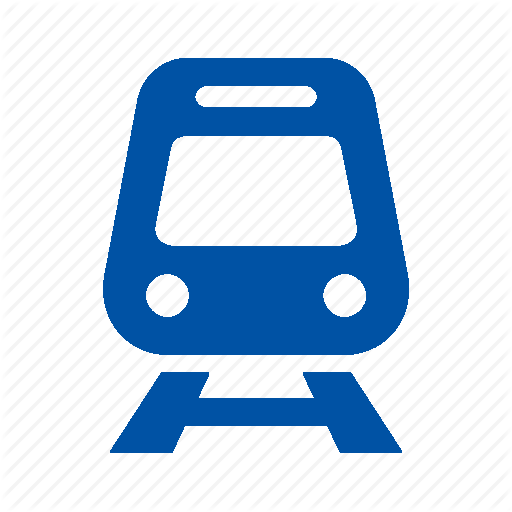
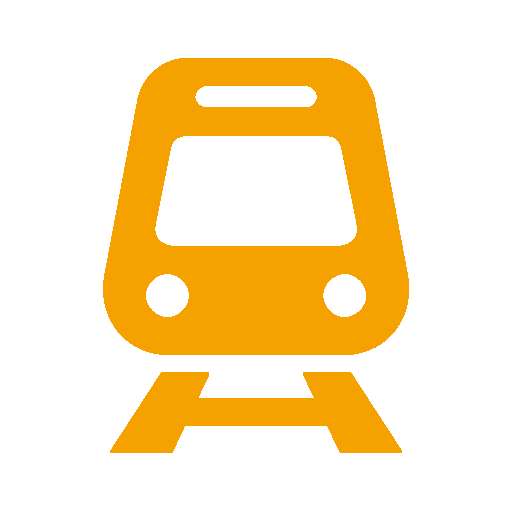
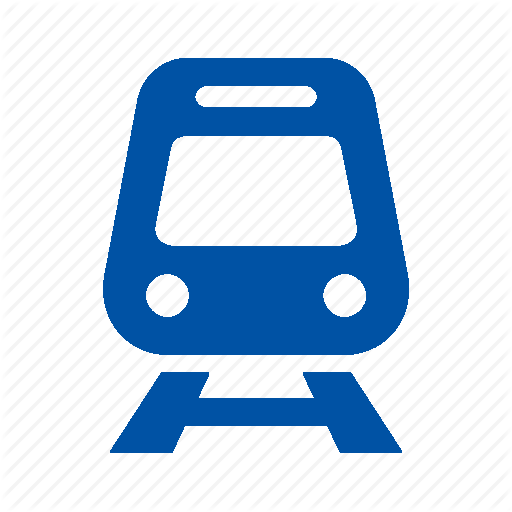
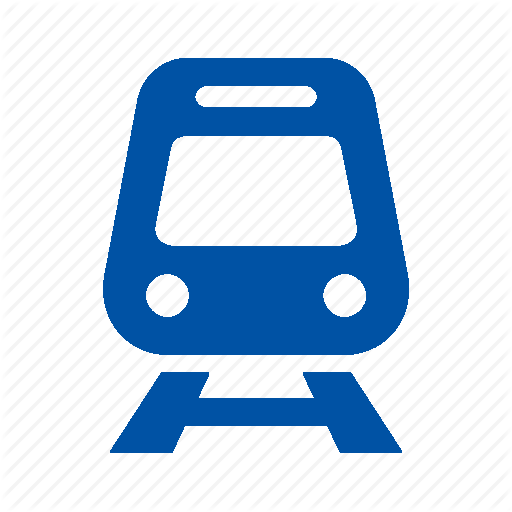
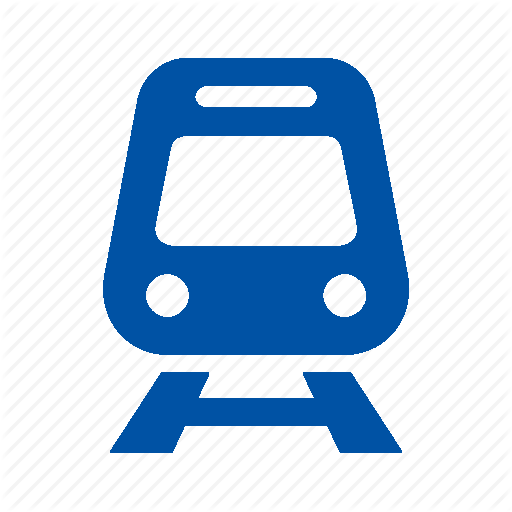
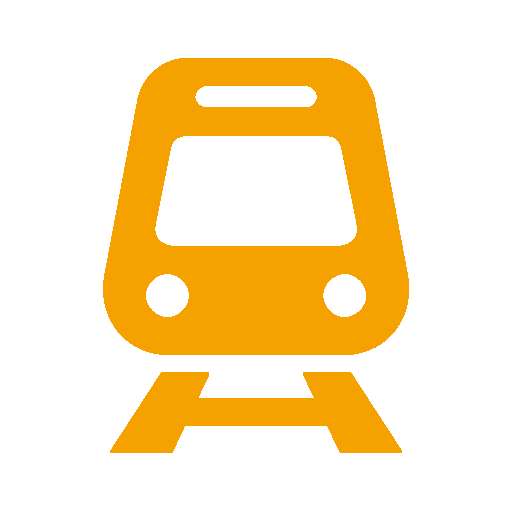
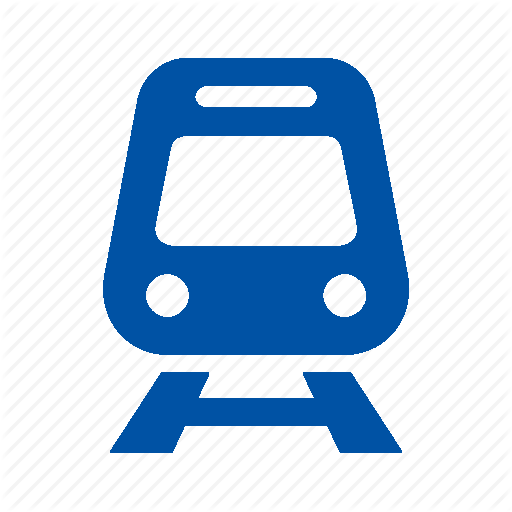
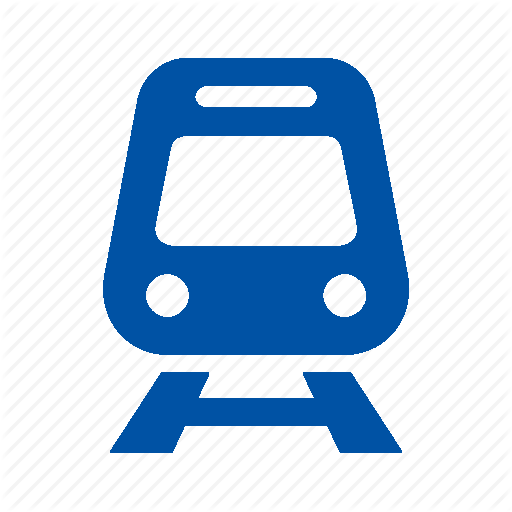

In [200]:
# 입력된 역의 좌표를 중심에서 맵을 보여줌
# 가공된 데이터 df1, df2를 사용해서 folium으로 맵에 마커를 찍음
# marker_cluster는 한 역에 여러대의 열차가 도착 or 출발하는 경우 마커가 겹처 원하는 결과를 못 얻는 것을 방지함
# icon_image는 subwayId를 1000으로 나눈 나머지를 인수로 받아 data/icons/의 sb-n의 아이콘 선택
# 해당되는 이미지가 없으면 sb-init 사용
# popup 메세지는 두 줄로 보여주기 위해 html형식으로 사용

stn_map = folium.Map(location=[lat,lng],zoom_start=13)
marker_cluster = MarkerCluster().add_to(stn_map)

for i in df1.index:
    icon_image = f'data/icons/sb-{df1.subwayId[i]%1000}.png'
    if not os.path.exists(icon_image):
        icon_image = f'data/icons/sb-init.png'
    pushpin = folium.CustomIcon(icon_image=icon_image, icon_size=(40,40))
    popup_text = f"{df1.arvlMsg2[i]}<br>{df1.updnLine[i]}"
    folium.Marker(
        location=[df1.lat[i], df1.lng[i]], 
        popup=folium.Popup(popup_text,max_width=300),
        tooltip=df1.arvlMsg3[i],
        icon=pushpin
    ).add_to(marker_cluster)

for i in df2.index:
    icon_image = f'data/icons/sb-{df2.subwayId[i]%1000}.png'
    if not os.path.exists(icon_image):
        icon_image = f'data/icons/sb-init.png'
    pushpin = folium.CustomIcon(icon_image=icon_image, icon_size=(40,40),)
    popup_text = f"{df2.arvlMsg2[i]}<br>{df2.updnLine[i]}"
    folium.Marker(
        location=[df2.lat[i], df2.lng[i]], 
        popup=folium.Popup(popup_text,max_width=300),
        tooltip=df2.arvlMsg3[i],
        icon=pushpin
    ).add_to(marker_cluster)

title_html = '<h3 align="center" style="font-size:20px">지하철 실시간 도착정보</h3>'
stn_map.get_root().html.add_child(folium.Element(title_html))
stn_map


In [201]:
# 상행 하행 구분 좀더 명확하게 - x
# 노선별로 아이콘 색 다르게 - id 1000으로 나눠서 1 -> 1호선 75 -> 수인분당 -> 수인선,경인선 추가해야함
# 급행도 아이콘 다르게 - x
# 검색한 역 아이콘 다르게 - 서클로? -> 생각좀
# 어? 근데 html에서 보여주려면 .values로 꺼내야 함?
what = df2.iloc[:,:6].values

In [202]:
what

array([['하행', '천안행 - 세류방면', '수원', '천안', '수원 도착', '수원'],
       ['하행', '인천행 - 고색방면', '수원', '인천', '[3]번째 전역 (매탄권선)', '매탄권선'],
       ['하행', '신창행 - 세류방면 (급행)', '수원', '신창 (급행)', '[6]번째 전역 (금정)', '금정'],
       ['하행', '서동탄행 - 세류방면', '수원', '서동탄', '[3]번째 전역 (의왕)', '의왕']],
      dtype=object)